In this model a few things that it took to make it work was
1. Introducing noise
2. While one hot encoding we put the value for correct label as 0.9 instead of 1.0
3. Not using Batch Normalization as mentioned in the DCGAN paper as it caused the failure of most of my models

In [ ]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5,), (0.5,)).cuda()])

train = torchvision.datasets.MNIST(root='/files/',train= True, transform=transform)

dataset = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True, num_workers=4)

In [ ]:
load_saved_model = False

In [ ]:
def one_hot_encoding(labels):
    finale = []
    for i in labels:
        final=[0.]*11
        final[i] = 0.9
        finale.append(final)
    finale = torch.Tensor(finale).cuda()
    return finale

In [ ]:
class Generator(nn.Module):
    
    def __init__(self) -> None:
        
        super().__init__()
        
        # Removed BatchNorm to check if the stability and performance of the model increases or not
        self.Linear = nn.Linear(in_features=11,out_features=32*(4)**2)
        self.upconv1a = nn.ConvTranspose2d(in_channels=32, out_channels=64, kernel_size= 3, stride=2, padding=1)
        self.upconv1b = nn.Sequential(nn.LeakyReLU(0.2))
        self.upconv2a = nn.ConvTranspose2d(in_channels=64, out_channels=128, kernel_size= 3, stride=2, padding=1, output_padding=1)
        self.upconv2b = nn.Sequential(nn.LeakyReLU(0.2))
        self.upconv3a = nn.ConvTranspose2d(in_channels=128, out_channels=1, kernel_size= 3, stride=2, padding=1, output_padding=1)
        self.upconv3b = nn.Tanh()
        
    def forward(self,x):
        
        x = self.Linear(x)
        x = x.view(32,32,4,4)
        x = self.upconv1a(x)
        x = self.upconv1b(x)
        x = self.upconv2a(x)
        x = self.upconv2b(x)
        x = self.upconv3a(x)
        x = self.upconv3b(x)
        
        return x

In [ ]:
class Discriminator(nn.Module):
    
    def __init__(self) -> None:
        
        super().__init__()
        
        self.conv1a = nn.Conv2d(in_channels=1, out_channels=128, kernel_size=3, stride=2, padding=1)
        self.conv1b = nn.Sequential(nn.BatchNorm2d(128),nn.LeakyReLU(0.2))
        self.conv2a = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1)
        self.conv2b = nn.Sequential(nn.BatchNorm2d(256),nn.LeakyReLU(0.2))
        self.conv3a = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1)
        self.conv3b = nn.Sequential(nn.BatchNorm2d(512),nn.LeakyReLU(0.2))
        self.conv4a = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4)
        self.conv4b = nn.Sequential(nn.BatchNorm2d(1024),nn.LeakyReLU(0.2))
        self.final = nn.Linear(in_features=1024,out_features=11)
        
    def forward(self,x):
        
        x = self.conv1a(x)
        x = self.conv1b(x)
        x = self.conv2a(x)
        x = self.conv2b(x)
        x = self.conv3a(x)
        x = self.conv3b(x)
        x = self.conv4a(x)
        x = self.conv4b(x)
        x = x.view(32,1024)
        x = self.final(x)
        x = nn.Softmax(1)(x)
        
        return x

In [ ]:
x = torch.rand(32,1,28,28)
x = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1)(x)
x = nn.Sequential(nn.BatchNorm2d(32),nn.LeakyReLU(0.2))(x)
x = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1, groups=32)(x)
x = nn.Sequential(nn.BatchNorm2d(64),nn.LeakyReLU(0.2))(x)
x = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1, groups=64)(x)
x = nn.Sequential(nn.BatchNorm2d(128),nn.LeakyReLU(0.2))(x)
x = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=4, groups=128)(x)
x = nn.Sequential(nn.BatchNorm2d(128),nn.LeakyReLU(0.2))(x)
print(x.shape)

torch.Size([32, 128, 1, 1])


In [ ]:
x = torch.rand(32,128,4,4)
x = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size= 3, padding=1, stride=2, groups=64)(x)
x = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size= 3, stride=2, padding=1, output_padding=1, groups=32)(x)
x = nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size= 3, stride=2, padding=1, output_padding=1)(x)
x.shape

torch.Size([32, 1, 28, 28])

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
generator = Generator().cuda()
try:
    if load_saved_model:
        generator.load_state_dict(torch.load('C:\\Users\\get2b\\Desktop\\Arav\\Neural Networks\\2. Pytorch implementation\\0. All Models Saved\\GeneratorDCGAN.pth'))
        print("Loading the saved model...")
    else:
        generator.load_state_dict(torch.load('C:\\Users\\Arav\\Neural Networks\\2. Pytorch implementation\\0. All Models Saved\\DiscriminatorDCGAN.pth'))
except:
    print("Initializing with uniform distribution...")
    def weights_init(m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)
    generator.apply(weights_init)

Initializing with uniform distribution...


In [ ]:
discriminator = Discriminator().cuda()
try:
    if load_saved_model:
        discriminator.load_state_dict(torch.load('C:\\Users\\get2b\\Desktop\\Arav\\Neural Networks\\2. Pytorch implementation\\0. All Models Saved\\DiscriminatorDCGAN.pth'))
        print("Loading the saved model...")
    else:
        discriminator.load_state_dict(torch.load('C:\\Users\\Desktop\\Arav\\Neural Networks\\2. Pytorch implementation\\0. All Models Saved\\DiscriminatorDCGAN.pth'))
except:
    print("Initializing with uniform distribution...")
    def weights_init(m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)
    discriminator.apply(weights_init)

Initializing with uniform distribution...


In [ ]:
optimizerGenerator = torch.optim.Adam(generator.parameters(),lr = 0.0002, betas=[0.5,0.999])
optimizerDisciminator = torch.optim.Adam(discriminator.parameters(),lr = 0.0002, betas=[0.5,0.999])

'''lr_scheduler_generator = torch.optim.lr_scheduler.StepLR(optimizer=optimizerGenerator,step_size=3,gamma=0.75)
lr_scheduler_discriminator = torch.optim.lr_scheduler.StepLR(optimizer=optimizerDisciminator,step_size=3,gamma=0.75)'''

loss = nn.CrossEntropyLoss()

In [ ]:
true_target = 0.9
G_losses = []
D_losses = []

In [ ]:
def generate_fake_target():
    generated_target = [0.]*11
    generated_target[10] = 0.9
    generated_target = [generated_target]*32
    generated_target = torch.Tensor(generated_target).cuda()
    return generated_target

In [ ]:
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean().cpu())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    
# Apply this right before loss.backwards() and before optimizer.step() to check the gradient flow of your network

Adding noise to label doesnt help us at all as it just makes our output worse and doesnt bring about any change in our output

In [ ]:
def train(num_epochs):
    
    for epoch in range(0,num_epochs):
    
        for i,data in enumerate(dataset,0):
            
            # We load the images onto the GPU and then make the real and fake targets
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            labels = one_hot_encoding(labels)
            real_target = labels
            fake_target = generate_fake_target()

            optimizerDisciminator.zero_grad(set_to_none=False)
            # We will now train the discriminator on real and generated images
            generated_images = generator(labels).detach()
            generated_images = generated_images + torch.Tensor(np.random.uniform(0.0,0.3,generated_images.size())).cuda()         # Adding noise to make it learn more ways to write
            output_through_discriminator = discriminator(generated_images.detach())
            generated_error = loss(output_through_discriminator,fake_target)
            generated_error.backward()
            images = images + torch.Tensor(np.random.uniform(0.0,0.3,images.size())).cuda()                                        # Adding noise to make it learn more ways to write
            real_images_through_discriminator = discriminator(images)
            real_error = loss(real_images_through_discriminator,real_target)
            real_error.backward()
            optimizerDisciminator.step()
            error_discriminator = real_error + generated_error
            
            optimizerGenerator.zero_grad(set_to_none=False)
            # We will now train the generator
            generated_images_G = generator(labels)
            generated_images_G = generated_images_G + torch.Tensor(np.random.uniform(0.0,0.3,generated_images_G.size())).cuda()    # Adding noise to make it learn more ways to write
            output = discriminator(generated_images_G)
            generator_loss = loss(output,labels)
            generator_loss.backward()
            optimizerGenerator.step()
            
            if i%50 == 0:
                print('[%d/%d][%d/%d]\t\tReal_Loss_D: %.4f\tFake_Loss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, num_epochs, i, len(dataset),
                     real_error,generated_error, generator_loss.item()))
            
            # Save Losses for plotting later
            G_losses.append(generator_loss.item())
            D_losses.append(error_discriminator.item())
        
        '''lr_scheduler_generator.step()
        lr_scheduler_discriminator.step()'''

In [ ]:
train(5)

[0/5][0/1875]		Real_Loss_D: 2.1645	Fake_Loss_D: 2.1561	Loss_G: 2.1737
[0/5][50/1875]		Real_Loss_D: 1.5753	Fake_Loss_D: 1.4859	Loss_G: 2.2575
[0/5][100/1875]		Real_Loss_D: 1.5862	Fake_Loss_D: 1.4295	Loss_G: 2.2708
[0/5][150/1875]		Real_Loss_D: 1.5552	Fake_Loss_D: 1.4098	Loss_G: 2.2765
[0/5][200/1875]		Real_Loss_D: 1.4771	Fake_Loss_D: 1.4079	Loss_G: 2.2831
[0/5][250/1875]		Real_Loss_D: 1.4121	Fake_Loss_D: 1.4092	Loss_G: 2.2847
[0/5][300/1875]		Real_Loss_D: 1.4452	Fake_Loss_D: 1.3982	Loss_G: 2.2864
[0/5][350/1875]		Real_Loss_D: 1.4759	Fake_Loss_D: 1.3953	Loss_G: 2.2846
[0/5][400/1875]		Real_Loss_D: 1.4978	Fake_Loss_D: 1.3961	Loss_G: 2.2853
[0/5][450/1875]		Real_Loss_D: 1.3985	Fake_Loss_D: 1.3958	Loss_G: 2.2856
[0/5][500/1875]		Real_Loss_D: 1.4277	Fake_Loss_D: 1.3939	Loss_G: 2.2875
[0/5][550/1875]		Real_Loss_D: 1.4519	Fake_Loss_D: 1.3953	Loss_G: 2.2859
[0/5][600/1875]		Real_Loss_D: 1.4010	Fake_Loss_D: 1.3931	Loss_G: 2.2873
[0/5][650/1875]		Real_Loss_D: 1.4487	Fake_Loss_D: 1.3949	Loss_G: 2.

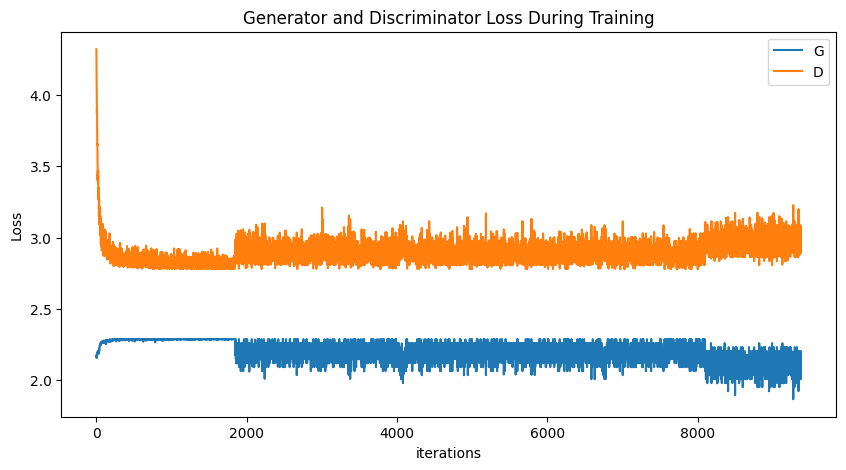

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

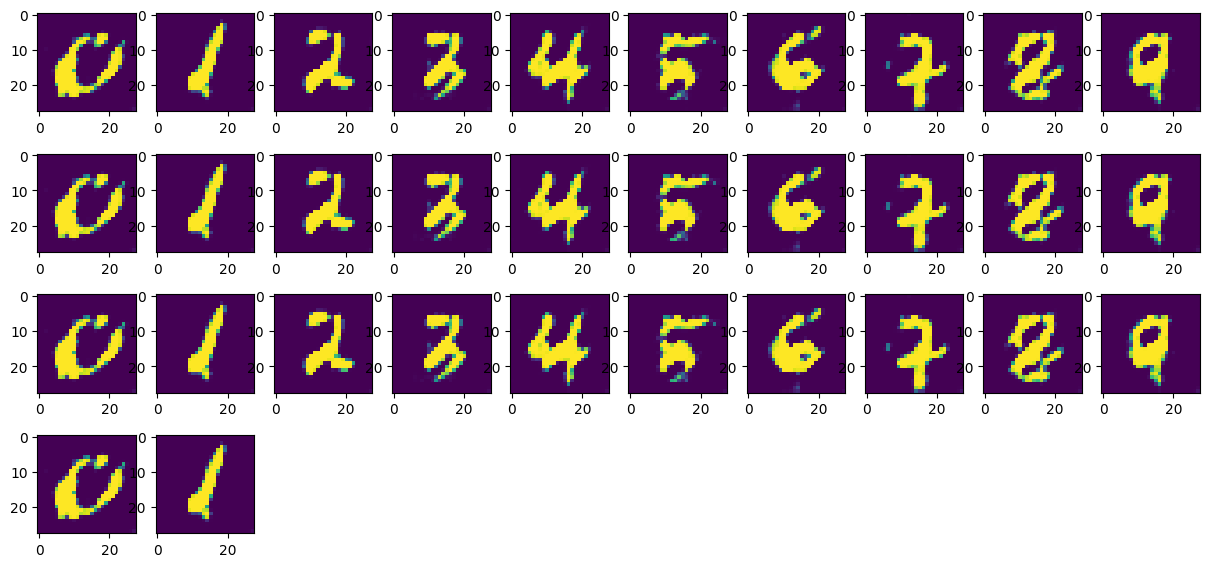

In [ ]:
def progress():
    generator.eval()
    labels = [0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1]
    labels = one_hot_encoding(labels)
    '''labels = labels + torch.Tensor(np.random.uniform(0.0,0.1,labels.size())).cuda()'''
    generated_images = generator(labels)
    rows = 4
    columns = 10
    fig = plt.figure(figsize=(15, 7))
    for i in range(1,33):
        fig.add_subplot(rows, columns, i)
        plt.imshow(generated_images[i-1][0].cpu().detach().numpy())
        plt.grid(visible=False)
progress()

In [ ]:
'''torch.save(generator.state_dict(), 'C:\\Users\\get2b\\Desktop\\Arav\\Neural Networks\\2. Pytorch implementation\\0. All Models Saved\\GeneratorDCGAN.pth')
torch.save(discriminator.state_dict(), 'C:\\Users\\get2b\\Desktop\\Arav\\Neural Networks\\2. Pytorch implementation\\0. All Models Saved\\DiscriminatorDCGAN.pth')'''

"torch.save(generator.state_dict(), 'C:\\Users\\get2b\\Desktop\\Arav\\Neural Networks\\2. Pytorch implementation\\0. All Models Saved\\GeneratorDCGAN.pth')\ntorch.save(discriminator.state_dict(), 'C:\\Users\\get2b\\Desktop\\Arav\\Neural Networks\\2. Pytorch implementation\\0. All Models Saved\\DiscriminatorDCGAN.pth')"